## Arrumando o Dataset

In [22]:
import os
import cv2

dataset_directory = ".\dataset"
images = []
labels = []

In [23]:
os.listdir(dataset_directory)

['andean', 'black', 'grizzly', 'malayanus', 'panda', 'polar', 'sloth', 'teddy']

In [24]:
for folder_name in os.listdir(dataset_directory):
    folder_path = os.path.join(dataset_directory, folder_name)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            resized_image = cv2.resize(image, (256, 256))
            images.append(resized_image)
            labels.append(folder_name);

In [25]:
print(len(images))
print(len(labels))

1341
1341


## Verificando se tudo ocorreu corretamente.

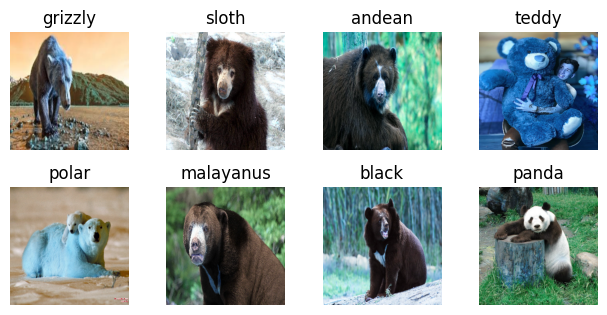

In [26]:
import numpy as np
import matplotlib.pyplot as plt

unique_labels = list(set(labels))
num_labels = len(unique_labels)
num_labels_per_line = 4
labels_array = np.array(labels)

for i, label in enumerate(unique_labels):
    index = labels_array.tolist().index(label)
    image = images[index]
    plt.subplot(num_labels // num_labels_per_line + 1, num_labels_per_line, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [27]:
images = np.array(images)
images = images / 255.0
labels = np.array(labels)

## Dividindo em Dados de treinamento e Validação

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 1072
Testing set size: 269


## Padronizando os dados

In [29]:
X_train = X_train.reshape(len(X_train), 256, 256, 3)
X_test = X_test.reshape(len(X_test), 256, 256, 3)

In [30]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [31]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [32]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0.]


In [33]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation
from keras.initializers import he_normal
from keras.optimizers import Adam

## Criando Modelo 

In [34]:
from keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = Sequential(
    [
        base_model,
        Flatten(),
        Dense(256, activation='elu'),
        Dropout(0.2),
        Dense(8, activation='softmax')
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [23]:
'''
# Criando camadas do modelo

model = Sequential(
    [
        InputLayer(input_shape=(256, 256, 3)),
        Rescaling(1./255),

        Conv2D(32, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),

        Dense(256, activation='relu', kernel_initializer=he_normal()),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_initializer=he_normal()),
        BatchNormalization(),
        Dropout(0.5),

        Dense(8, activation='softmax')
    ]
)

# Compilando modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
'''

In [35]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath = 'model.keras',
    monitor ='val_categorical_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)

## Treinando de fato o modelo

In [37]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 0.7610 - categorical_accuracy: 0.7341
Epoch 1: val_categorical_accuracy improved from 0.63569 to 0.78439, saving model to model.keras
34/34 [==============================] - 140s 4s/step - loss: 0.7610 - categorical_accuracy: 0.7341 - val_loss: 0.7092 - val_categorical_accuracy: 0.7844
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 0.4132 - categorical_accuracy: 0.8713
Epoch 2: val_categorical_accuracy did not improve from 0.78439
34/34 [==============================] - 132s 4s/step - loss: 0.4132 - categorical_accuracy: 0.8713 - val_loss: 0.7616 - val_categorical_accuracy: 0.7658
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 0.2574 - categorical_accuracy: 0.9198
Epoch 3: val_categorical_accuracy improved from 0.78439 to 0.81784, saving model to model.keras
34/34 [==============================] - 132s 4s/step - loss: 0.2574 - categorical_accuracy: 0.9198 - val_loss: 0.59

## Visualizando os resultados

In [38]:
best_model_accuracy = max(history.history['categorical_accuracy'])
best_model_val_accuracy = max(history.history['val_categorical_accuracy'])

print("Training Accuracy :", best_model_accuracy)
print("Validation Accuracy :", best_model_val_accuracy)

Training Accuracy : 1.0
Validation Accuracy : 0.8661710023880005


In [39]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_test_labels, y_pred_labels)

9/9 [==============================] - 23s 2s/step


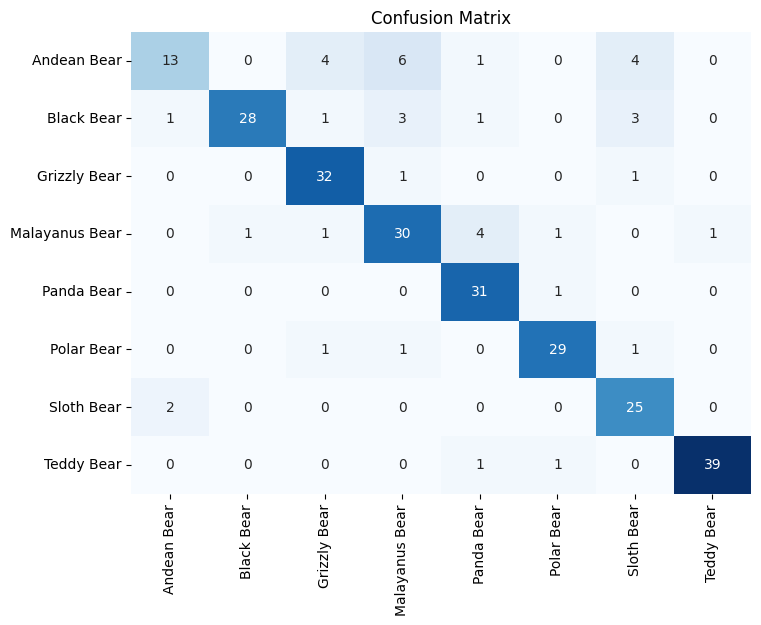

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_mtx,
    annot=True,
    cbar=False,
    fmt='d',
    cmap="Blues",
    xticklabels=['Andean Bear', 'Black Bear', 'Grizzly Bear', 'Malayanus Bear', 'Panda Bear', 'Polar Bear', 'Sloth Bear', 'Teddy Bear'],
    yticklabels=['Andean Bear', 'Black Bear', 'Grizzly Bear', 'Malayanus Bear', 'Panda Bear', 'Polar Bear', 'Sloth Bear', 'Teddy Bear'],
)

plt.title('Confusion Matrix')
plt.show()

In [41]:
from sklearn.metrics import recall_score

recall = recall_score(y_test_labels, y_pred_labels, average=None)
print("Recall:", recall)

Recall: [0.46428571 0.75675676 0.94117647 0.78947368 0.96875    0.90625
 0.92592593 0.95121951]
